In [16]:
import numpy as np
import os, sys, cv2, time
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, init, autograd, nd, image
from mxnet.gluon import data as gdata, utils as gutils, nn, loss as gloss
from mxnet.gluon.data.vision import datasets, transforms
from sklearn.metrics import confusion_matrix
from ipywidgets import interact, IntSlider

In [17]:
#target_folder = 'E:/Guan-Ming/Deep_ML/all_data_resize/'
#output_folder = 'E:/Guan-Ming/Deep_ML/all_data_final_transposed/'
#test_data_folder = 'E:/Guan-Ming/Deep_ML/test_data_resize/'
#extra_validation_target_folder = 'E:/Guan-Ming/Deep_ML/extra_validation_data_resize/'

train_x_folder = 'all_data_resize_Grey/'
train_y_folder = 'all_data_resize/'
test_x_folder = 'test_data_gray_to_RGB/'

In [18]:
cd E:/Guan-Ming/Deep_ML/

E:\Guan-Ming\Deep_ML


### Read in Training Data

In [19]:
files = os.listdir(train_x_folder)
total_data = len(files)
train_data_x = nd.zeros((total_data, 256, 256, 3)).astype(np.uint8)
train_data_y = nd.zeros((total_data, 256, 256, 3))
total_num = 0

for index, f in enumerate(files):
    train_data_x[index] = image.imread(train_x_folder+f)
    label = f.split('_',2)[2]
    train_data_y[index] = image.imread(train_y_folder+label)
    train_data_y[index] /= 255
    total_num += 1
    
if total_num == total_data:
    print("Sum check pass!")

Sum check pass!


### Read in Testing Data

In [20]:
files = os.listdir(test_x_folder)
total_test_data = len(files)
test_data_x = nd.zeros((total_test_data, 256, 256, 3)).astype(np.uint8)
total_num = 0

for index in range(total_test_data):
    f = files[index]
    test_data_x[index] = image.imread(test_x_folder+f)
        
if total_num == total_test_data:
    print("Sum check pass!")

In [21]:
train_mean = [0.5905187523955868, 0.5332879723913606, 0.49680592040529487]  #over all data
train_std = [0.28736647217403904, 0.28094815765222825, 0.2815392173263535]  #over all data

### Create Data Iterator

In [22]:
batch_size = 8
num_workers = 0

train_dataset = gdata.ArrayDataset(train_data_x, train_data_y)
test_dataset = gdata.ArrayDataset(test_data_x)
    
transformer = []
transformer += [gdata.vision.transforms.ToTensor()] # transer the train data from shape (sample, H, W, channel) to (sample, channel, H, W) and rescale to between 0 and 1 
transformer += [gdata.vision.transforms.Normalize(train_mean, train_std)]
transformer = gdata.vision.transforms.Compose(transformer)

train_iter = gdata.DataLoader(train_dataset.transform_first(transformer), batch_size = batch_size, shuffle=True, num_workers=num_workers)
test_iter = gdata.DataLoader(test_dataset.transform_first(transformer), batch_size = batch_size, shuffle=False, num_workers=num_workers)

### Define Functions for Training

In [23]:
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx
# def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
#     """Evaluate accuracy of a model on the given data set."""
#     if isinstance(ctx, mx.Context):
#         ctx = [ctx]
#     acc_sum, n = nd.array([0]), 0
#     for batch in data_iter:
#         features, labels, _ = _get_batch(batch, ctx)
#         for X, y in zip(features, labels):
#             y = y.astype('float32')
#             acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
#             n += y.size
#         acc_sum.wait_to_read()
#     return acc_sum.asscalar() / n

def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(net, train_iter, batch_size, trainer, ctx, num_epochs, early_stop = False, temp_train_loss = 100.0):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', ctx)
    loss = gloss.L2Loss()
    average_time = 0.0
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        if early_stop:
            net.save_parameters('./temp_net_weight.params')
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)            
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            train_l_sum += l.asscalar()
            n += len(y)
        
#        test_acc = evaluate_accuracy(test_iter, net, ctx)
        epoch_time = time.time() - start
        train_loss = train_l_sum/n
        print('epoch %d, loss %.4f, time %.1f sec' % (epoch + 1, train_loss, epoch_time))
        average_time += epoch_time
        
        if early_stop:
            if temp_train_loss<train_loss:
                break
            else:
                temp_train_loss = train_loss
    print('Average time per epoch is %.4f s.'%(average_time/(epoch+1)))

In [24]:
ctx = try_gpu()

In [25]:
# class Residual(nn.Block):
#     def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
#         super(Residual, self).__init__(**kwargs) 
#         self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides) # this layer down-sampling the input
#         self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)  # the layer doesn't down-sampling the input
        
#         if use_1x1conv:
#             self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
#             # to match the dimension of feature map of conv1 + conv2, the strides must be set to be identicla to conv 1
#         else: 
#             self.conv3 = None 
            
#         self.bn1 = nn.BatchNorm() 
#         self.bn2 = nn.BatchNorm()
        
#     def forward(self, X):
#         Y = nd.relu(self.bn1(self.conv1(X)))
#         Y = self.bn2(self.conv2(Y)) 
#         if self.conv3:
#             X = self.conv3(X)

#         return nd.relu(Y + X)
    
# def resnet_block(num_channels, num_residuals, first_block=False): 
#     blk = nn.Sequential() 
#     for i in range(num_residuals): 
#         if i == 0 and not first_block:
#             #net.add(Residual(num_channels, use_1x1conv=True, strides=2))
#             blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
#         else:
#             #net.add(Residual(num_channels, strides=1))
#             blk.add(Residual(num_channels, strides=1))
#     return blk

In [26]:
# num_of_output_channels = [64, 128, 256, 512]
# num_residuals = [3, 4, 6, 3]

# net_RESNET = nn.Sequential() 
# net_RESNET.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
#         nn.BatchNorm(), 
#         nn.Activation('relu'),
#         nn.MaxPool2D(pool_size=3, strides=2, padding=1))

# for i, num in enumerate(num_of_output_channels):
#     if i==0:
#         net_RESNET.add(resnet_block(num, num_residuals[i], first_block=True))
#     else:
#         net_RESNET.add(resnet_block(num, num_residuals[i]))
#     net_RESNET.add(nn.Dropout(0.1))

# net_RESNET.add(nn.GlobalAvgPool2D(), nn.Dense(6))

In [27]:
net = nn.Sequential()
net.add(nn.Conv2D(128, kernel_size=1), nn.Conv2D(256, kernel_size=1), nn.Conv2D(512, kernel_size=1))
net.add(nn.Conv2D(256, kernel_size=1), nn.Conv2D(128, kernel_size=1), nn.Conv2D(64, kernel_size=1))
net.add(nn.Conv2D(32, kernel_size=1), nn.Conv2D(16, kernel_size=1), nn.Conv2D(8, kernel_size=1))
net.add(nn.Conv2D(3, kernel_size=1))

### Initialize or Load Weights

In [28]:
net.initialize(ctx=ctx, init=mx.init.Xavier(rnd_type ='gaussian', factor_type='in', magnitude=2.0))

In [29]:
for X,y in train_iter:
    net.summary(X.as_in_context(ctx))
    break

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (8, 3, 256, 256)               0
            Conv2D-1                          (8, 128, 256, 256)             512
            Conv2D-2                          (8, 256, 256, 256)           33024
            Conv2D-3                          (8, 512, 256, 256)          131584
            Conv2D-4                          (8, 256, 256, 256)          131328
            Conv2D-5                          (8, 128, 256, 256)           32896
            Conv2D-6                           (8, 64, 256, 256)            8256
            Conv2D-7                           (8, 32, 256, 256)            2080
            Conv2D-8                           (8, 16, 256, 256)             528
            Conv2D-9                            (8, 8, 256, 256)             136
           Conv2D-10        

### Training

In [31]:
adam_optimizer = mx.optimizer.Adam(learning_rate=1e-3, beta1=0.9, beta2=0.9)
trainer = gluon.Trainer(net.collect_params(), optimizer=adam_optimizer)
train(net, train_iter, batch_size, trainer, ctx, 10, False)

training on gpu(0)
epoch 1, loss 0.2297, time 17.4 sec
epoch 2, loss 0.0349, time 17.8 sec
epoch 3, loss 0.0346, time 17.6 sec
epoch 4, loss 0.0334, time 17.7 sec
epoch 5, loss 0.0333, time 17.7 sec
epoch 6, loss 0.0332, time 17.6 sec
epoch 7, loss 0.0326, time 17.6 sec
epoch 8, loss 0.0329, time 17.8 sec
epoch 9, loss 0.0322, time 17.7 sec
epoch 10, loss 0.0327, time 17.6 sec
Average time per epoch is 17.6454 s.


In [34]:
for X in test_iter:
    test_data_y = net(X.as_in_context(ctx))

In [44]:
np.floor(255*test_data_y[0].asnumpy())

array([[[161., 160., 160., ..., 160., 159., 161.],
        [160., 160., 160., ..., 160., 159., 161.],
        [160., 160., 160., ..., 160., 160., 161.],
        ...,
        [128., 123., 122., ..., 160., 144., 140.],
        [131., 128., 128., ..., 156., 143., 140.],
        [137., 136., 138., ..., 146., 143., 143.]],

       [[170., 170., 170., ..., 169., 168., 170.],
        [170., 170., 170., ..., 169., 169., 170.],
        [170., 170., 170., ..., 170., 169., 171.],
        ...,
        [131., 126., 125., ..., 169., 150., 145.],
        [135., 132., 131., ..., 165., 149., 146.],
        [142., 141., 143., ..., 153., 150., 150.]],

       [[154., 153., 153., ..., 153., 152., 154.],
        [153., 153., 153., ..., 153., 152., 154.],
        [153., 153., 153., ..., 153., 153., 154.],
        ...,
        [119., 114., 113., ..., 153., 136., 131.],
        [122., 119., 119., ..., 149., 135., 132.],
        [129., 128., 129., ..., 138., 135., 135.]]], dtype=float32)

In [37]:
img = np.floor(255*test_data_y[0].asnumpy()).astype(np.uint8)
img_reshape = np.zeros((256,256,3), dtype=np.uint8)
for channel in range(3):
    img_reshape[:,:,channel] = img[channel,:,:]

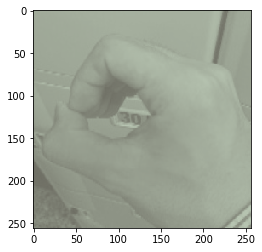

In [38]:
import matplotlib.pyplot as plt
plt.imshow(img_reshape)

In [ ]:
img_reshape.shape